# Samsung Coding Challenge

**Exploration Notebook -- Bertrand Delorme -- 23/05/2018**

## Overview

In this notebook, I justify the choices that I made to solve the coding challenge by showing the exploration process I went through.

## Steps followed

1. Data import
2. Data visualization
3. Model1: Random Forest
4. Model2: Seasonal Arima

## Libraries used

- numpy for efficient data structures and functions for scientific computing.
- pandas for data manipulation and data analysis.
- matplotlib for data visualization.
- scikit-learn for Random Forest implementation.
- statsmodels for Seasonal Arima implementation.

## Libraries import

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


from src.process_data import read_raw_data, preprocess_RF, preprocess_AR, split_train_test
from src.visualize_data import global_infos, time_series, correlation_features, autocorrelation_temp, plot_prediction, decompose_plots

## 1. Data import

Here, we import the data. At the same time, we set the 'date/heure' feature to index and construct the label 'TEMP+1'.

In [2]:
data = read_raw_data('data/qualite-de-lair-mesuree-dans-la-station-franklin-d-roosevelt_date_sorted.csv')

print('{} instances for {} features.'.format(data.shape[0], data.shape[1]-1))

35039 instances for 6 features.


In [3]:
data.sample(5)

,NO,NO2,PM10,CO2,TEMP,HUMI,TEMP+1
date/heure,,,,,,,
2016-04-16 02:00:00,16.0,57.0,11.0,430.0,18.3,46.2,18.8
2014-09-27 17:00:00,32.0,68.0,22.0,520.0,24.6,43.8,24.6
2013-09-23 09:00:00,51.0,56.0,42.0,459.0,22.6,51.9,22.8
2015-11-14 16:00:00,34.0,67.0,28.0,440.0,16.3,49.8,16.4
2015-03-17 17:00:00,32.0,94.0,51.0,526.0,NaN,NaN,NaN


## 2. Data Visualization

In [4]:
glob_infos = global_infos(data)
display(glob_infos)

,Type,#NaN,Min,Max,Mean,Median,std
NO,float64,3690,2.0,929.0,46.537178,33.0,46.768235
NO2,float64,3356,5.0,242.0,62.358552,62.0,21.584286
PM10,float64,1691,5.0,979.0,41.227240,33.0,37.919407
CO2,float64,3188,390.0,1056.0,479.098929,471.0,55.731307
TEMP,float64,1293,5.7,33.1,18.457065,18.2,5.029331
HUMI,float64,1302,19.6,95.4,49.707772,49.6,10.283184
TEMP+1,float64,1294,5.7,33.1,18.457164,18.2,5.029373


$\rightarrow$ no unrealistic values but presence of gaps, particularly for NO, NO2 and CO2.

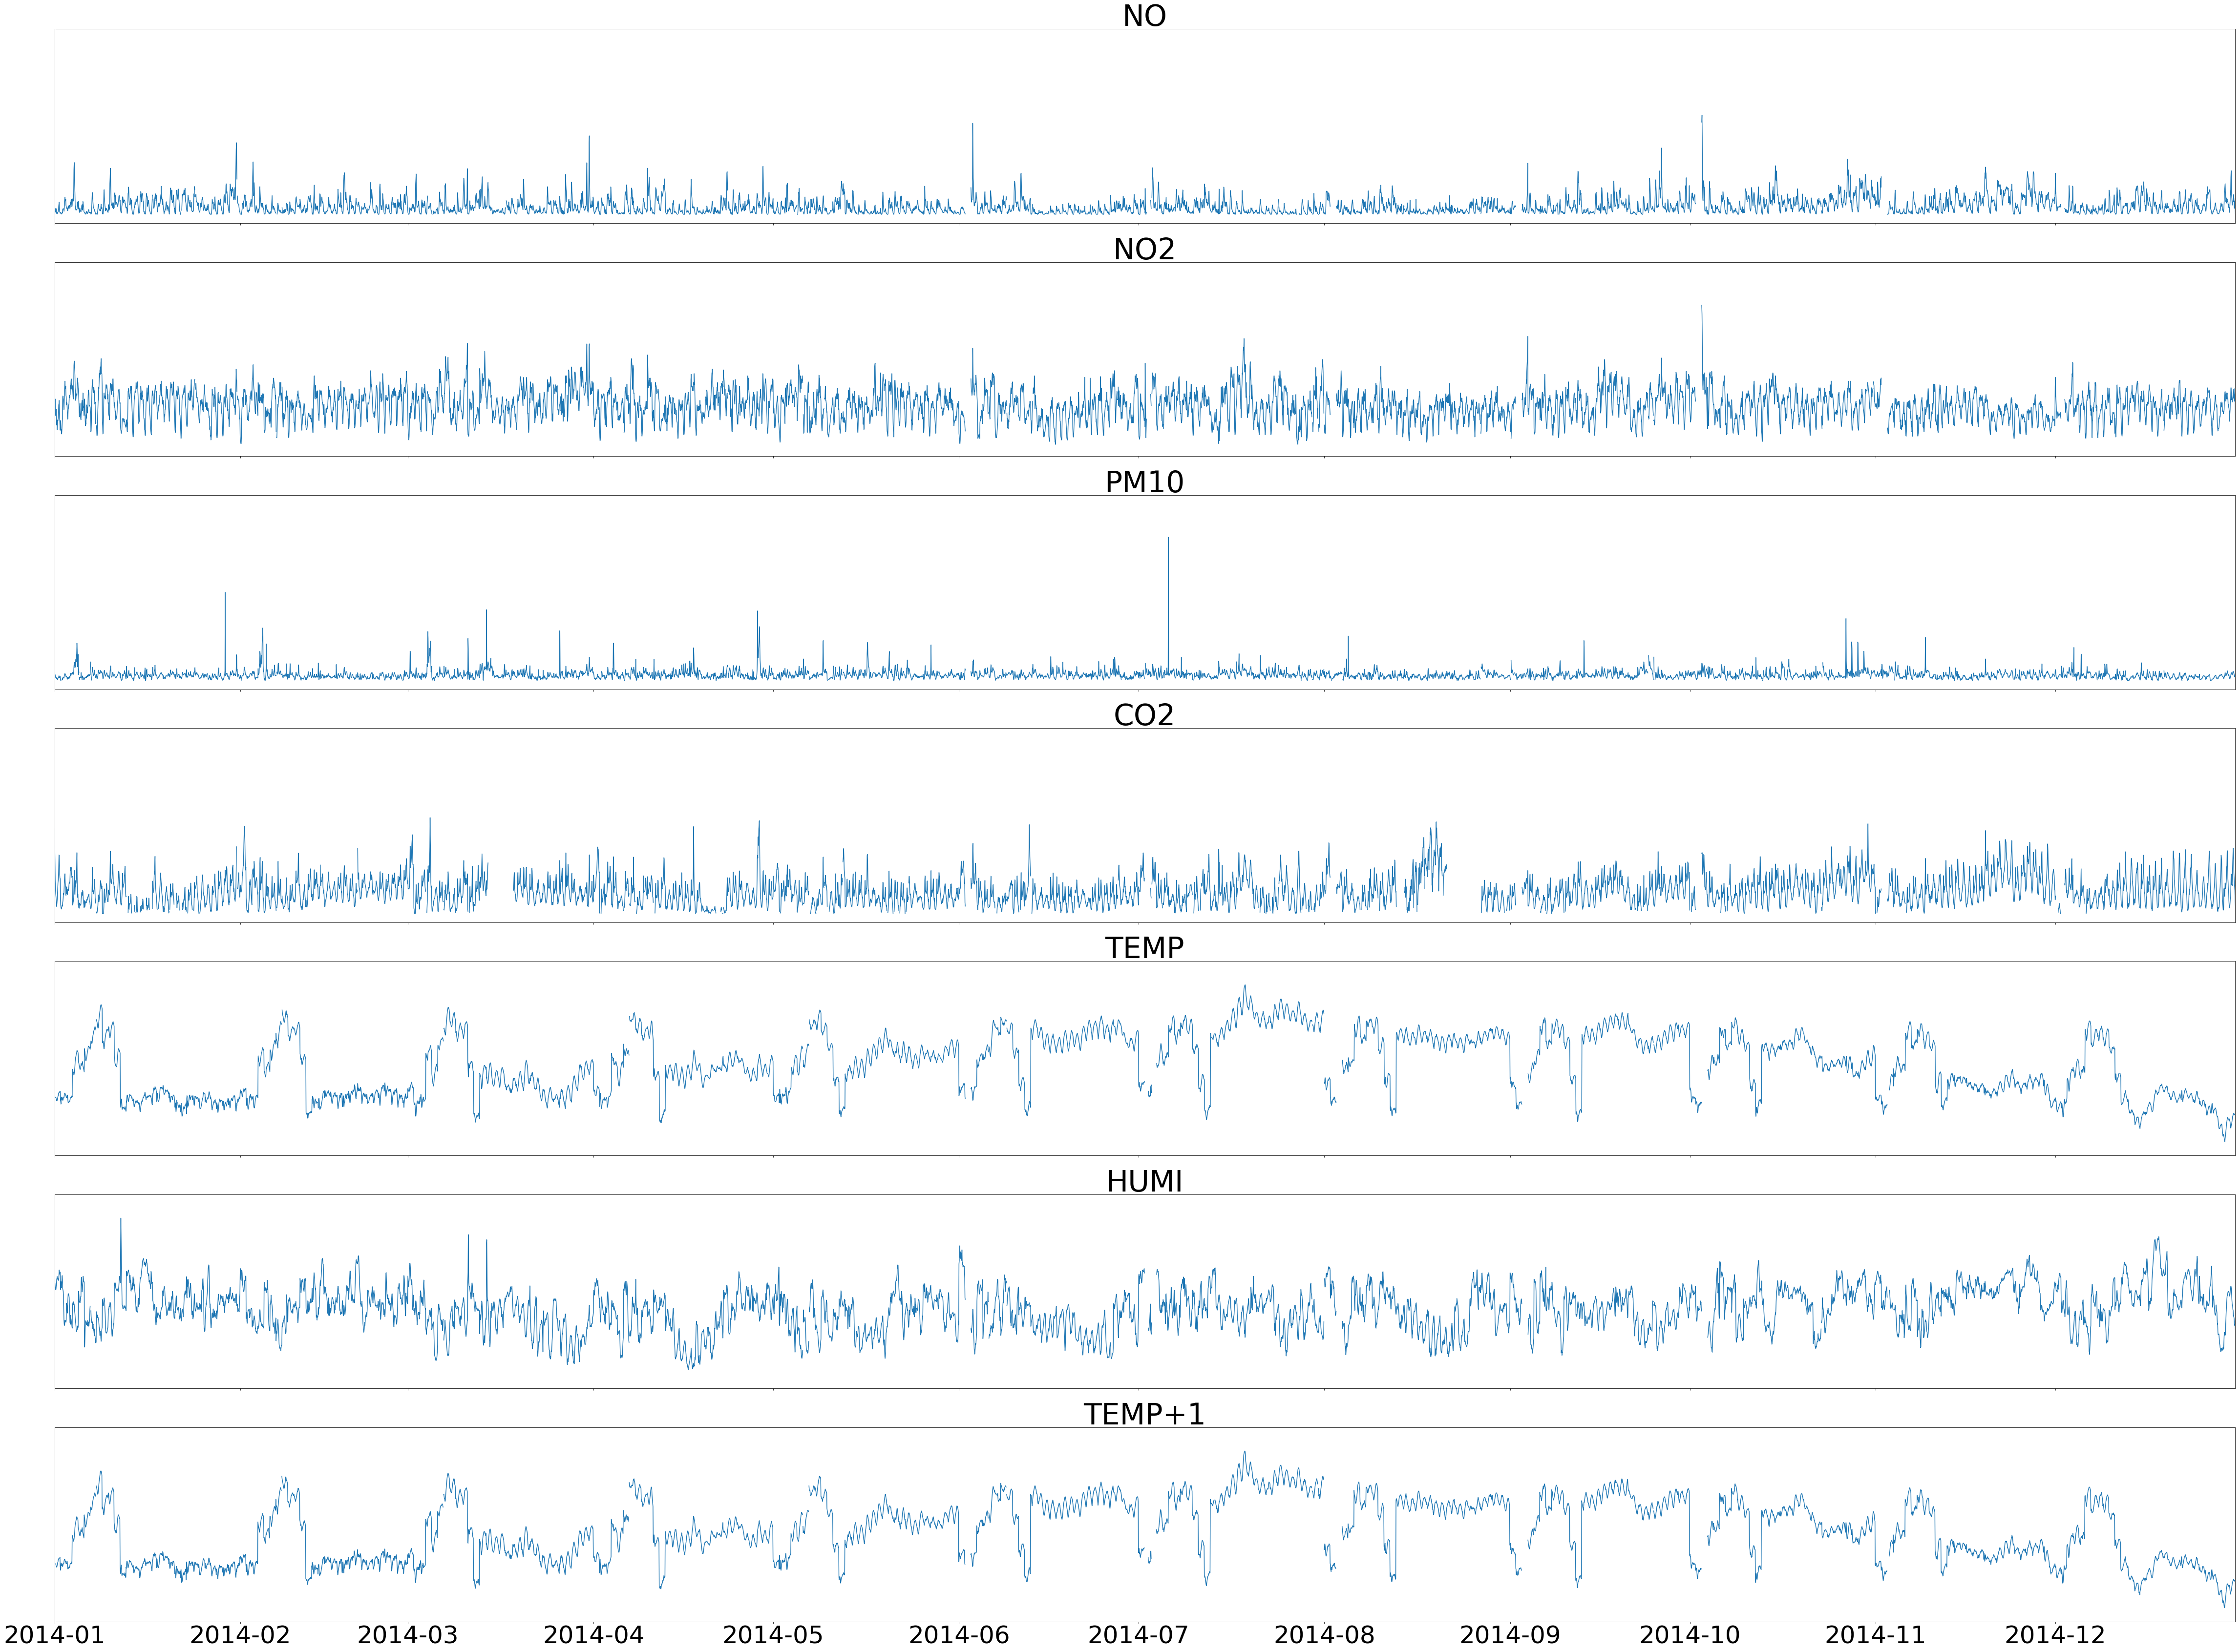

In [5]:
# change time range here to zoom/dezoom in the time series
# format: time_series(dframe, year1, month1, day1, year2, month2, day2)
f = time_series(data, 2014, 1, 1, 2014, 12, 31)

$\rightarrow$ Rather noisy data.

$\rightarrow$ Other features do not seem to correlate well with TEMP.

$\rightarrow$ seasonality with hotter values on average in the summer and colder values in the winter.

$\rightarrow$ heating event occurs at the beginning of each month followed by an opposite cooling event.

$\rightarrow$ presence of a diurnal cycle.

In [6]:
corr = correlation_features(data)
display(corr)

,NO,NO2,PM10,CO2,TEMP,HUMI,TEMP+1
NO,1.000000,0.513895,0.326259,0.504125,-0.241274,0.170002,-0.228029
NO2,0.513895,1.000000,0.194424,0.432237,0.079191,-0.193386,0.091807
PM10,0.326259,0.194424,1.000000,0.505803,0.064914,-0.090951,0.072701
CO2,0.504125,0.432237,0.505803,1.000000,-0.102007,-0.048290,-0.087828
TEMP,-0.241274,0.079191,0.064914,-0.102007,1.000000,-0.243077,0.991501
HUMI,0.170002,-0.193386,-0.090951,-0.048290,-0.243077,1.000000,-0.239225
TEMP+1,-0.228029,0.091807,0.072701,-0.087828,0.991501,-0.239225,1.000000


$\rightarrow$ confirm that other features don't have a strong influence on TEMP.

(0, 1)

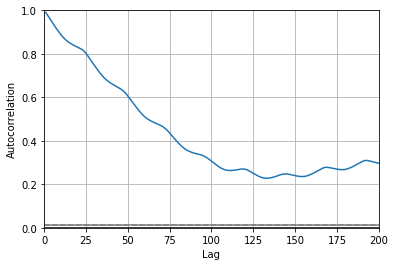

In [7]:
f = autocorrelation_temp(data)
plt.xlim([0,200])
plt.ylim([0,1])

$\rightarrow$ value at h+1 highly autocorrelated to prior values (significant autocorrelation for lag up to 50h).

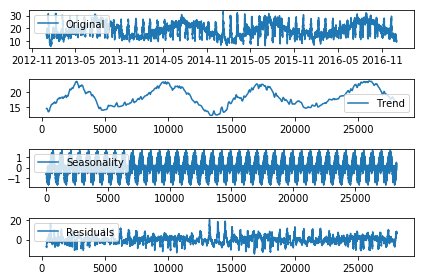

In [8]:
decompose_plots(data)

$\rightarrow$ multiple seasonality.

## 3. Model1: Random Forest

Here, we make the null hypothesis that knowledge of the state at h-1 and h is enough to predict accurately the state at h+1.

### a- Feature Engineering

Based on the data visualization step, we drop all features except TEMP at time h, and add 3 new features:
- TEMP at h-1
- the hour of the day
- the day of the month

We also remove all missing values from our dataframe.

In [9]:
X, y, X_last = preprocess_RF(data)
X.head(5)

,TEMP,hour_of_day,day_of_month,TEMP-1
date/heure,,,,
2013-01-01 02:00:00,14.9,2,1,15.1
2013-01-01 03:00:00,14.9,3,1,14.9
2013-01-01 04:00:00,14.9,4,1,14.9
2013-01-01 05:00:00,15.0,5,1,14.9
2013-01-01 06:00:00,15.1,6,1,15.0


### b- Split between train and test set

In [10]:
X_train, X_test, y_train, y_test = split_train_test(X, y)

### c- Grid Search and Cross-Validation

NB: Grid Search takes around 5min to run so we commented it and choose directly the best values for the parameters.

In [11]:
'''
param_search = {'n_estimators' : [10, 100, 1000], 'max_depth' : [5, 10, 50, None]}
my_cv = TimeSeriesSplit(n_splits=4).split(X_train)
gsearch = GridSearchCV(estimator=RandomForestRegressor(), cv=my_cv, param_grid=param_search, scoring='r2')
gsearch.fit(X_train, y_train)

print('Grid best parameter (max. r2): ', gsearch.best_params_)
print('Grid best score (r2): ', gsearch.best_score_)
'''
gsearch = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=0).fit(X_train, y_train)

### d- Scores and plot

Train R2 score: 0.99573720392323
Train MSE: 0.10871059050417017
Test R2 score: 0.9866481024206982
Test MSE: 0.28714621942586793


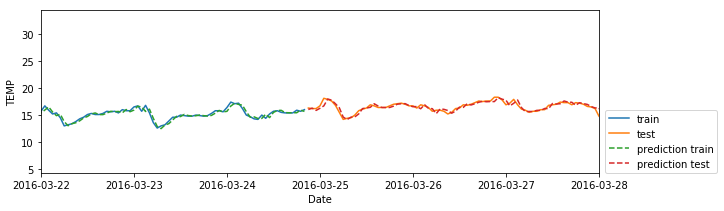

In [12]:
# Prediction
y_pred_test = gsearch.predict(X_test)
y_pred_train = gsearch.predict(X_train)

# Scores
print('Train R2 score: {}'.format(gsearch.score(X_train, y_train)))
print('Train MSE: {}'.format(mean_squared_error(y_train, y_pred_train)))
print('Test R2 score: {}'.format(gsearch.score(X_test, y_test)))
print('Test MSE: {}'.format(mean_squared_error(y_test, y_pred_test)))

# Plot
plot_prediction(y_train, y_test, y_pred_train, y_pred_test, 
                2016, 3, 22, 2016, 3, 28)

This is a pretty nice performance. Yet, looking closely at the curve, we can understand that the model tend to reproduce the temperature at time h-1 for time h. In this way, it sometimes lag a timestep at some point. A good way to remediate to that - that I would try to implement if I had the time - is to transform the time series in Fourier space, back up the remarquable periods of the signal, and use TEMP at those intervals in the Random Forest algorithm. An other solution would be to look at more complex auto-regressiv models, where all previous observations have equal weights. This is what I tried below.

## 4. Model2: Seasonal Arima

This model is widely used in time series prediction. Here, we will implement it looking at temperature data only. As a first step, we need to ensure stationarity of the data. I am doing that below with a Dickey-Fuller Test.

In [13]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=window, min_periods=1)
    rolstd = pd.rolling_std(timeseries, window=window, min_periods=1)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/Users/bdelorme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=720,min_periods=1,center=False).mean()
  after removing the cwd from sys.path.
/Users/bdelorme/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=720,min_periods=1,center=False).std()
  """


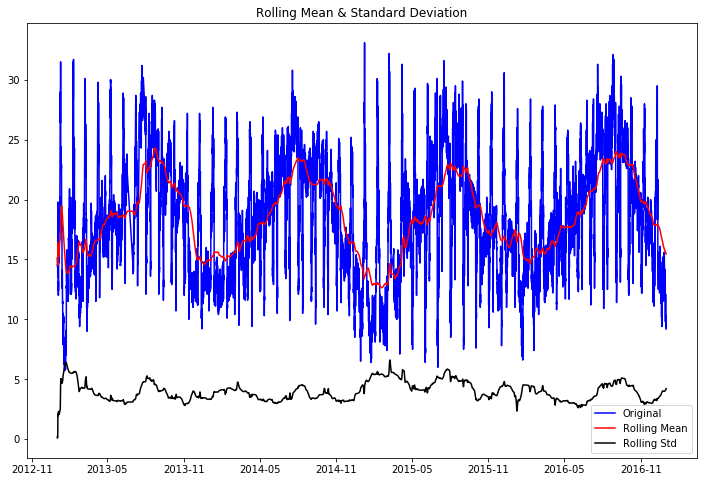

Results of Dickey-Fuller Test:
Test Statistic                -1.331091e+01
p-value                        6.749476e-25
#Lags Used                     5.000000e+01
Number of Observations Used    3.369500e+04
Critical Value (1%)           -3.430544e+00
Critical Value (5%)           -2.861626e+00
Critical Value (10%)          -2.566816e+00
dtype: float64


In [14]:
data = preprocess_AR(data)
window = 30*24
test_stationarity(data.TEMP, window)

Test statistic much lower than 1% critical value. So, we can say with 99% confidence level that the dataset is a stationary series.

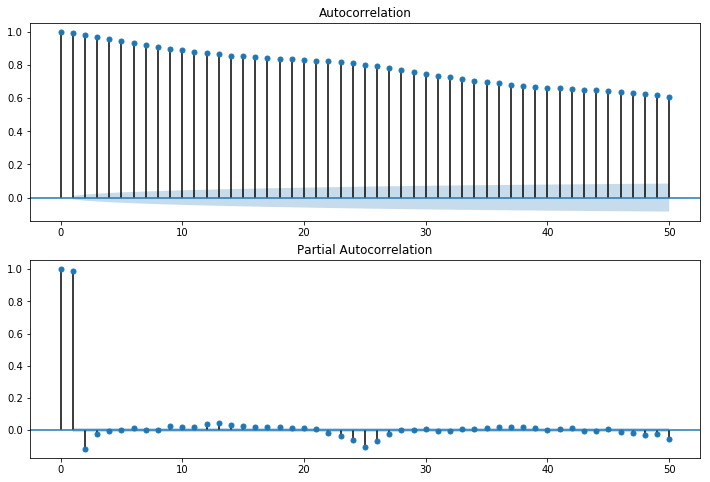

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.TEMP, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.TEMP, lags=50, ax=ax2)

It seems that a strong anti-correlation occurs at a daily lag. We will use that as a measure of seasonality.

NB: the code below takes around 3min to run.

In [16]:
mod = sm.tsa.statespace.SARIMAX(data.TEMP, order=(1,1,1), seasonal_order=(0,1,1,24))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               TEMP   No. Observations:                33746
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -34335.447
Date:                            Wed, 23 May 2018   AIC                          68678.894
Time:                                    19:53:57   BIC                          68712.600
Sample:                                01-01-2013   HQIC                         68689.649
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0182      0.111      0.165      0.869      -0.198       0.235
ma.L1          0.0440      0.110   

R2: 0.9818543114410687
MSE: 0.45896658078636743


(736312.0, 736330.0)

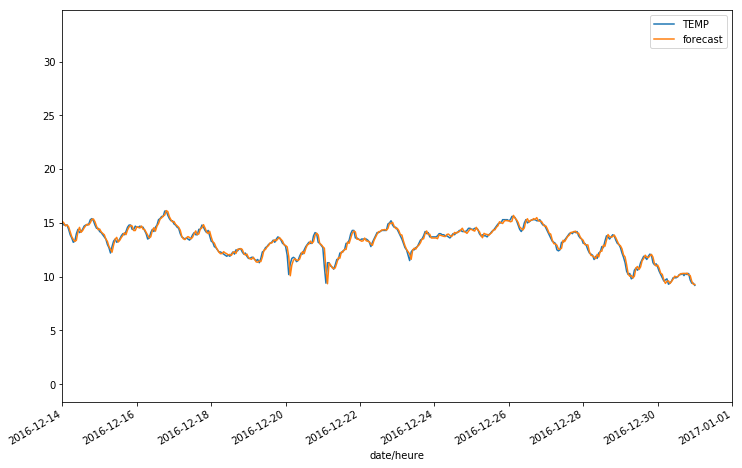

In [17]:
date_lim_inf = dt.date(2016, 12, 14)
date_lim_sup = dt.date(2017, 1, 1)
data['forecast'] = results.predict(dynamic=False) 

# score
print('R2: {}'.format(r2_score(data['TEMP'], data['forecast'])))
print('MSE: {}'.format(mean_squared_error(data['TEMP'], data['forecast'])))



data[['TEMP', 'forecast']].plot(figsize=(12, 8))
plt.xlim([date_lim_inf,date_lim_sup])

Interestingly, the Seasonal Arimax seems to do poorer than the Random Forest Algorithm. Hence, we will keep the Random Forest algorithm as our response for the coding challenge.